# XGBoost Models | with feature selection and normalized data

**XGBRegressor**

Josie Donnelly

*Last updated 11.10.22*

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
from statistics import mode
from datetime import datetime
from time import time
import random

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

from xgboost import XGBRegressor


## Preprocessing

In [2]:
# load merged dataset
path = r'/Users/josiedonnelly/Desktop/DS Capstone ENGIE4800/data/'
file = 'float_loc_data_new_vars2.csv'

date_parser = lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
df_orig = pd.read_csv(path + file, parse_dates=['date'], date_parser=date_parser)
df_orig


,float,latitude,longitude,cycleNumber,date,PRES,PSAL,TEMP,BBP700,CHLA,...,sat_pic,sat_Rrs_678,sat_aph_443,sat_par,sat_angstrom,sat_bb_678,sat_adg_443,sat_aot_869,sat_adg_s,sat_bbp_s
0,1902303,49.236,-14.742,1,2021-05-06 02:03:16,3,35.539001,12.378333,0.001788,6.958747e-01,...,0.000306,0.000354,0.0357,27.891998,1.1175,0.001995,0.0083,0.0951,0.018,1.600373
1,1902303,49.236,-14.742,1,2021-05-06 02:03:16,4,35.539001,12.378333,0.001788,6.958747e-01,...,0.000306,0.000354,0.0357,27.891998,1.1175,0.001995,0.0083,0.0951,0.018,1.600373
2,1902303,49.236,-14.742,1,2021-05-06 02:03:16,6,35.539001,12.378667,0.001788,6.964993e-01,...,0.000306,0.000354,0.0357,27.891998,1.1175,0.001995,0.0083,0.0951,0.018,1.600373
3,1902303,49.236,-14.742,1,2021-05-06 02:03:16,8,35.539001,12.379000,0.001789,7.164887e-01,...,0.000306,0.000354,0.0357,27.891998,1.1175,0.001995,0.0083,0.0951,0.018,1.600373
4,1902303,49.236,-14.742,1,2021-05-06 02:03:16,10,35.539001,12.379000,0.001790,7.155517e-01,...,0.000306,0.000354,0.0357,27.891998,1.1175,0.001995,0.0083,0.0951,0.018,1.600373
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33210612,7901001,17.330,-23.271,28,2022-05-23 11:34:00,968,34.916109,6.358057,0.000216,-3.686869e-05,...,0.000142,0.000266,0.0122,59.995998,0.5624,0.001425,0.0086,0.1181,0.018,1.906093
33210613,7901001,17.330,-23.271,28,2022-05-23 11:34:00,975,34.916280,6.346782,0.000216,-1.843434e-05,...,0.000142,0.000266,0.0122,59.995998,0.5624,0.001425,0.0086,0.1181,0.018,1.906093
33210614,7901001,17.330,-23.271,28,2022-05-23 11:34:00,977,34.916280,6.346782,0.000216,2.543358e-18,...,0.000142,0.000266,0.0122,59.995998,0.5624,0.001425,0.0086,0.1181,0.018,1.906093
33210615,7901001,17.330,-23.271,28,2022-05-23 11:34:00,982,34.916280,6.346782,0.000216,2.543358e-18,...,0.000142,0.000266,0.0122,59.995998,0.5624,0.001425,0.0086,0.1181,0.018,1.906093


In [3]:
df_orig.columns


Index(['float', 'latitude', 'longitude', 'cycleNumber', 'date', 'PRES', 'PSAL',
       'TEMP', 'BBP700', 'CHLA', 'short_date', 'sat_chl', 'sat_ipar',
       'sat_sst', 'sat_poc', 'sat_bbp_443', 'sat_a_678', 'sat_kd_490',
       'sat_nflh', 'sat_pic', 'sat_Rrs_678', 'sat_aph_443', 'sat_par',
       'sat_angstrom', 'sat_bb_678', 'sat_adg_443', 'sat_aot_869', 'sat_adg_s',
       'sat_bbp_s'],
      dtype='object')

In [4]:
df = df_orig[['float', 'cycleNumber', 'latitude', 'longitude', 'date', 'sat_chl', 'sat_sst', 'sat_pic', 'sat_par', 'sat_aph_443', 'PRES', 'TEMP', 'CHLA']]
# sat_chl: chlorophyll-a concentration
# sat_sst: sea surface temperature
# sat_pic: calcite concentration
# sat_par: photosynthetically available radiation
# sat_aph_443: absorption due to phytoplankton (443 nm)

# add a column for the day of the year in radians
df.insert(loc=list(df.columns).index('date')+1, column='day_of_year_rad', value=[(int(d.strftime('%j'))*np.pi)/182.625 for d in df['date']])

# consider only the observations for which the target CHLA is available
df = df[~df['CHLA'].isna()].reset_index(drop=True)
df


,float,cycleNumber,latitude,longitude,date,day_of_year_rad,sat_chl,sat_sst,sat_pic,sat_par,sat_aph_443,PRES,TEMP,CHLA
0,1902303,1,49.236,-14.742,2021-05-06 02:03:16,2.167505,0.370203,12.610,0.000306,27.891998,0.0357,3,12.378333,6.958747e-01
1,1902303,1,49.236,-14.742,2021-05-06 02:03:16,2.167505,0.370203,12.610,0.000306,27.891998,0.0357,4,12.378333,6.958747e-01
2,1902303,1,49.236,-14.742,2021-05-06 02:03:16,2.167505,0.370203,12.610,0.000306,27.891998,0.0357,6,12.378667,6.964993e-01
3,1902303,1,49.236,-14.742,2021-05-06 02:03:16,2.167505,0.370203,12.610,0.000306,27.891998,0.0357,8,12.379000,7.164887e-01
4,1902303,1,49.236,-14.742,2021-05-06 02:03:16,2.167505,0.370203,12.610,0.000306,27.891998,0.0357,10,12.379000,7.155517e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33076991,7901001,28,17.330,-23.271,2022-05-23 11:34:00,2.459947,0.117684,23.705,0.000142,59.995998,0.0122,968,6.358057,-3.686869e-05
33076992,7901001,28,17.330,-23.271,2022-05-23 11:34:00,2.459947,0.117684,23.705,0.000142,59.995998,0.0122,975,6.346782,-1.843434e-05
33076993,7901001,28,17.330,-23.271,2022-05-23 11:34:00,2.459947,0.117684,23.705,0.000142,59.995998,0.0122,977,6.346782,2.543358e-18
33076994,7901001,28,17.330,-23.271,2022-05-23 11:34:00,2.459947,0.117684,23.705,0.000142,59.995998,0.0122,982,6.346782,2.543358e-18


In [5]:
# ensure the rows of the dataframe are unique
df.shape[0] == df.drop_duplicates().shape[0]


True

## Create a train-test split grouping by float and cycle

In [6]:
df.insert(loc=list(df.columns).index('cycleNumber')+1, column='float_cycle_id', value=[f'{df.loc[i,"float"]}_{df.loc[i,"cycleNumber"]}'for i in range(df.shape[0])])
df


,float,cycleNumber,float_cycle_id,latitude,longitude,date,day_of_year_rad,sat_chl,sat_sst,sat_pic,sat_par,sat_aph_443,PRES,TEMP,CHLA
0,1902303,1,1902303_1,49.236,-14.742,2021-05-06 02:03:16,2.167505,0.370203,12.610,0.000306,27.891998,0.0357,3,12.378333,6.958747e-01
1,1902303,1,1902303_1,49.236,-14.742,2021-05-06 02:03:16,2.167505,0.370203,12.610,0.000306,27.891998,0.0357,4,12.378333,6.958747e-01
2,1902303,1,1902303_1,49.236,-14.742,2021-05-06 02:03:16,2.167505,0.370203,12.610,0.000306,27.891998,0.0357,6,12.378667,6.964993e-01
3,1902303,1,1902303_1,49.236,-14.742,2021-05-06 02:03:16,2.167505,0.370203,12.610,0.000306,27.891998,0.0357,8,12.379000,7.164887e-01
4,1902303,1,1902303_1,49.236,-14.742,2021-05-06 02:03:16,2.167505,0.370203,12.610,0.000306,27.891998,0.0357,10,12.379000,7.155517e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33076991,7901001,28,7901001_28,17.330,-23.271,2022-05-23 11:34:00,2.459947,0.117684,23.705,0.000142,59.995998,0.0122,968,6.358057,-3.686869e-05
33076992,7901001,28,7901001_28,17.330,-23.271,2022-05-23 11:34:00,2.459947,0.117684,23.705,0.000142,59.995998,0.0122,975,6.346782,-1.843434e-05
33076993,7901001,28,7901001_28,17.330,-23.271,2022-05-23 11:34:00,2.459947,0.117684,23.705,0.000142,59.995998,0.0122,977,6.346782,2.543358e-18
33076994,7901001,28,7901001_28,17.330,-23.271,2022-05-23 11:34:00,2.459947,0.117684,23.705,0.000142,59.995998,0.0122,982,6.346782,2.543358e-18


In [7]:
print(f'Number of float-cycle pairs: {len(np.unique(df["float_cycle_id"]))}')


Number of float-cycle pairs: 58450


In [8]:
# split data indices into train and test dataframes grouped by float_cycle_id
from sklearn.model_selection import GroupShuffleSplit
splitter = GroupShuffleSplit(test_size=0.2, n_splits=1, random_state=42)
split = splitter.split(df, groups=df['float_cycle_id'])
train_inds, test_inds = next(split)


In [9]:
print(f'Number of train observations: {len(train_inds)}')
print(f'Number of float-cycle observations: {len(test_inds)}')


Number of train observations: 26456594
Number of float-cycle observations: 6620402


In [10]:
train_df = df.loc[train_inds]
train_df


,float,cycleNumber,float_cycle_id,latitude,longitude,date,day_of_year_rad,sat_chl,sat_sst,sat_pic,sat_par,sat_aph_443,PRES,TEMP,CHLA
0,1902303,1,1902303_1,49.236,-14.742,2021-05-06 02:03:16,2.167505,0.370203,12.61,0.000306,27.891998,0.0357,3,12.378333,6.958747e-01
1,1902303,1,1902303_1,49.236,-14.742,2021-05-06 02:03:16,2.167505,0.370203,12.61,0.000306,27.891998,0.0357,4,12.378333,6.958747e-01
2,1902303,1,1902303_1,49.236,-14.742,2021-05-06 02:03:16,2.167505,0.370203,12.61,0.000306,27.891998,0.0357,6,12.378667,6.964993e-01
3,1902303,1,1902303_1,49.236,-14.742,2021-05-06 02:03:16,2.167505,0.370203,12.61,0.000306,27.891998,0.0357,8,12.379000,7.164887e-01
4,1902303,1,1902303_1,49.236,-14.742,2021-05-06 02:03:16,2.167505,0.370203,12.61,0.000306,27.891998,0.0357,10,12.379000,7.155517e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33076554,7901001,27,7901001_27,17.316,-23.379,2022-05-18 11:27:00,2.373934,0.136086,23.66,0.000018,58.424000,0.0122,953,6.339257,1.978669e-18
33076555,7901001,27,7901001_27,17.316,-23.379,2022-05-18 11:27:00,2.373934,0.136086,23.66,0.000018,58.424000,0.0122,955,6.319870,1.978669e-18
33076556,7901001,27,7901001_27,17.316,-23.379,2022-05-18 11:27:00,2.373934,0.136086,23.66,0.000018,58.424000,0.0122,964,6.308070,1.978669e-18
33076557,7901001,27,7901001_27,17.316,-23.379,2022-05-18 11:27:00,2.373934,0.136086,23.66,0.000018,58.424000,0.0122,966,6.296271,1.978669e-18


In [11]:
test_df = df.loc[test_inds]
test_df


,float,cycleNumber,float_cycle_id,latitude,longitude,date,day_of_year_rad,sat_chl,sat_sst,sat_pic,sat_par,sat_aph_443,PRES,TEMP,CHLA
1411,1902303,4,1902303_4,48.794,-14.689,2021-05-08 22:42:52,2.201910,0.694757,12.639999,0.000136,54.299999,0.0486,3,12.451333,1.445162e+00
1412,1902303,4,1902303_4,48.794,-14.689,2021-05-08 22:42:52,2.201910,0.694757,12.639999,0.000136,54.299999,0.0486,4,12.451333,1.445162e+00
1413,1902303,4,1902303_4,48.794,-14.689,2021-05-08 22:42:52,2.201910,0.694757,12.639999,0.000136,54.299999,0.0486,6,12.452000,1.441414e+00
1414,1902303,4,1902303_4,48.794,-14.689,2021-05-08 22:42:52,2.201910,0.694757,12.639999,0.000136,54.299999,0.0486,8,12.453667,1.433294e+00
1415,1902303,4,1902303_4,48.794,-14.689,2021-05-08 22:42:52,2.201910,0.694757,12.639999,0.000136,54.299999,0.0486,10,12.455333,1.398625e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33076991,7901001,28,7901001_28,17.330,-23.271,2022-05-23 11:34:00,2.459947,0.117684,23.705000,0.000142,59.995998,0.0122,968,6.358057,-3.686869e-05
33076992,7901001,28,7901001_28,17.330,-23.271,2022-05-23 11:34:00,2.459947,0.117684,23.705000,0.000142,59.995998,0.0122,975,6.346782,-1.843434e-05
33076993,7901001,28,7901001_28,17.330,-23.271,2022-05-23 11:34:00,2.459947,0.117684,23.705000,0.000142,59.995998,0.0122,977,6.346782,2.543358e-18
33076994,7901001,28,7901001_28,17.330,-23.271,2022-05-23 11:34:00,2.459947,0.117684,23.705000,0.000142,59.995998,0.0122,982,6.346782,2.543358e-18


In [12]:
# ensure that the train and test float cycles are distinct
train_float_cycles = np.unique(train_df['float_cycle_id'])
test_float_cycles = np.unique(test_df['float_cycle_id'])
print(f'Number of unique train float-cycles: {len(np.unique(train_float_cycles))}')
print(f'Number of unique test float-cycles: {len(np.unique(test_float_cycles))}')
print(f'Number of float-cycle pairs in both train and test sets: {len(np.intersect1d(train_float_cycles, test_float_cycles))}')


Number of unique train float-cycles: 46760
Number of unique test float-cycles: 11690
Number of float-cycle pairs in both train and test sets: 0


## Define functions

In [2]:
# function to join CHLA data onto satellite information based on lat, long, and date
def get_data_by_depth(group_df, depth_bin):
       
    group_data_df = group_df[group_df['depth_bin'] == depth_bin]
    if 'normalized_depth' in group_data_df.columns:
        id_df = group_data_df[['depth_bin', 'float_cycle_id', 'date', 'PRES', 'normalized_depth', 'CHLA']].rename(columns={'CHLA': 'true_CHLA'})
        group_data_df = group_data_df.drop(columns=['float', 'cycleNumber', 'float_cycle_id', 'date', 'normalized_depth', 'depth_bin', 'TEMP'])
    else:
        id_df = group_data_df[['depth_bin', 'float_cycle_id', 'date', 'PRES', 'CHLA']].rename(columns={'CHLA': 'true_CHLA'})
        group_data_df = group_data_df.drop(columns=['float', 'cycleNumber', 'float_cycle_id', 'date', 'PRES', 'depth_bin', 'TEMP'])
    
    return group_data_df, id_df


In [3]:
def standardize(train_data_df, test_data_df):
        
    X_train = train_data_df.drop(columns='CHLA')
    y_train = train_data_df['CHLA']
    X_test = test_data_df.drop(columns='CHLA')
    y_test = test_data_df['CHLA']

    # perform (training) mean inputation for missing values by column
    for c in X_train.columns:
        c_train_mean = np.mean(X_train[c])
        X_train[c].fillna(value=c_train_mean, inplace=True)
        X_test[c].fillna(value=c_train_mean, inplace=True)
      
    ss = StandardScaler()
    X_train[X_train.columns] = ss.fit_transform(X_train[X_train.columns])
    X_test[X_test.columns] = ss.transform(X_test[X_test.columns])
    
    return X_train, X_test, y_train, y_test
          

In [4]:
# function to fit model on training and testing data
# returns predictions on train and test data
def fit_predict(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)
    
    return train_preds, test_preds
    

In [5]:
# display the results of the regression as scatter plots: predicted value vs. target
def plot(depth_idx, bins, y_train, train_preds, y_test, test_preds, normalized=False, plt_n_cols=5):  
    plt.subplot((len(bins)//plt_n_cols)+1,plt_n_cols,depth_idx+1)
    plt.scatter(y_train, train_preds, label=f'train (r2 = {r2_score(y_train, train_preds):.2f})', alpha=0.7)
    plt.scatter(y_test, test_preds, label=f'test (r2 = {r2_score(y_test, test_preds):.2f})', alpha=0.7)
    if normalized:
        plt.title(f'{int(bins[depth_idx]*100)}% to {int(bins[depth_idx+1]*100)}%', fontsize='x-large')
    else:
        plt.title(f'{bins[depth_idx]}m to {bins[depth_idx+1]}m', fontsize='x-large')
    plt.xlabel('true CHLA')
    plt.ylabel('predicted CHLA')
    plt.legend(loc='lower right')
    

## XGB regressor at varying depths

In [17]:
# define depth bins
max_depth = max(df['PRES'])
interval = 20
bins = np.arange(0, max_depth + interval, interval)
bins[-2] = bins[-1]
bins = bins[:-1]     # absporbing the deepest bin into the second deepest bin because there are so few observations

depth_bins = pd.cut(df['PRES'], bins=bins, right=True, labels=False, retbins=False, include_lowest=True)


In [18]:
try:
    train_df = train_df.drop(columns='depth_bin')
except:
    pass

train_df.insert(loc=list(train_df.columns).index('PRES')+1, column='depth_bin', value=depth_bins)
train_df


,float,cycleNumber,float_cycle_id,latitude,longitude,date,day_of_year_rad,sat_chl,sat_sst,sat_pic,sat_par,sat_aph_443,PRES,depth_bin,TEMP,CHLA
0,1902303,1,1902303_1,49.236,-14.742,2021-05-06 02:03:16,2.167505,0.370203,12.61,0.000306,27.891998,0.0357,3,0,12.378333,6.958747e-01
1,1902303,1,1902303_1,49.236,-14.742,2021-05-06 02:03:16,2.167505,0.370203,12.61,0.000306,27.891998,0.0357,4,0,12.378333,6.958747e-01
2,1902303,1,1902303_1,49.236,-14.742,2021-05-06 02:03:16,2.167505,0.370203,12.61,0.000306,27.891998,0.0357,6,0,12.378667,6.964993e-01
3,1902303,1,1902303_1,49.236,-14.742,2021-05-06 02:03:16,2.167505,0.370203,12.61,0.000306,27.891998,0.0357,8,0,12.379000,7.164887e-01
4,1902303,1,1902303_1,49.236,-14.742,2021-05-06 02:03:16,2.167505,0.370203,12.61,0.000306,27.891998,0.0357,10,0,12.379000,7.155517e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33076554,7901001,27,7901001_27,17.316,-23.379,2022-05-18 11:27:00,2.373934,0.136086,23.66,0.000018,58.424000,0.0122,953,47,6.339257,1.978669e-18
33076555,7901001,27,7901001_27,17.316,-23.379,2022-05-18 11:27:00,2.373934,0.136086,23.66,0.000018,58.424000,0.0122,955,47,6.319870,1.978669e-18
33076556,7901001,27,7901001_27,17.316,-23.379,2022-05-18 11:27:00,2.373934,0.136086,23.66,0.000018,58.424000,0.0122,964,48,6.308070,1.978669e-18
33076557,7901001,27,7901001_27,17.316,-23.379,2022-05-18 11:27:00,2.373934,0.136086,23.66,0.000018,58.424000,0.0122,966,48,6.296271,1.978669e-18


In [19]:
try:
    test_df = test_df.drop(columns='depth_bin')
except:
    pass

test_df.insert(loc=list(test_df.columns).index('PRES')+1, column='depth_bin', value=depth_bins)
test_df


,float,cycleNumber,float_cycle_id,latitude,longitude,date,day_of_year_rad,sat_chl,sat_sst,sat_pic,sat_par,sat_aph_443,PRES,depth_bin,TEMP,CHLA
1411,1902303,4,1902303_4,48.794,-14.689,2021-05-08 22:42:52,2.201910,0.694757,12.639999,0.000136,54.299999,0.0486,3,0,12.451333,1.445162e+00
1412,1902303,4,1902303_4,48.794,-14.689,2021-05-08 22:42:52,2.201910,0.694757,12.639999,0.000136,54.299999,0.0486,4,0,12.451333,1.445162e+00
1413,1902303,4,1902303_4,48.794,-14.689,2021-05-08 22:42:52,2.201910,0.694757,12.639999,0.000136,54.299999,0.0486,6,0,12.452000,1.441414e+00
1414,1902303,4,1902303_4,48.794,-14.689,2021-05-08 22:42:52,2.201910,0.694757,12.639999,0.000136,54.299999,0.0486,8,0,12.453667,1.433294e+00
1415,1902303,4,1902303_4,48.794,-14.689,2021-05-08 22:42:52,2.201910,0.694757,12.639999,0.000136,54.299999,0.0486,10,0,12.455333,1.398625e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33076991,7901001,28,7901001_28,17.330,-23.271,2022-05-23 11:34:00,2.459947,0.117684,23.705000,0.000142,59.995998,0.0122,968,48,6.358057,-3.686869e-05
33076992,7901001,28,7901001_28,17.330,-23.271,2022-05-23 11:34:00,2.459947,0.117684,23.705000,0.000142,59.995998,0.0122,975,48,6.346782,-1.843434e-05
33076993,7901001,28,7901001_28,17.330,-23.271,2022-05-23 11:34:00,2.459947,0.117684,23.705000,0.000142,59.995998,0.0122,977,48,6.346782,2.543358e-18
33076994,7901001,28,7901001_28,17.330,-23.271,2022-05-23 11:34:00,2.459947,0.117684,23.705000,0.000142,59.995998,0.0122,982,49,6.346782,2.543358e-18


In [20]:
# initialize dataframe to store results
results_df = pd.DataFrame(columns=['depth_idx', 'depth_interval', 'num_observations', 'train_mse', 'train_r2', 'test_mse', 'test_r2'])


DEPTH 0: 0m to 20m
	Num train samples: 749915  |  Num test samples: 187937
	Train MSE: 0.0395  |  Train r2: 0.9186
	Test MSE: 0.1863   |  Test r2: 0.6372

DEPTH 1: 20m to 40m
	Num train samples: 760312  |  Num test samples: 190497
	Train MSE: 0.0632  |  Train r2: 0.8631
	Test MSE: 0.2068   |  Test r2: 0.5862

DEPTH 2: 40m to 60m
	Num train samples: 760214  |  Num test samples: 190417
	Train MSE: 0.0446  |  Train r2: 0.8253
	Test MSE: 0.1243   |  Test r2: 0.5140

DEPTH 3: 60m to 80m
	Num train samples: 759341  |  Num test samples: 190278
	Train MSE: 0.0234  |  Train r2: 0.8155
	Test MSE: 0.0584   |  Test r2: 0.5016

DEPTH 4: 80m to 100m
	Num train samples: 756517  |  Num test samples: 189505
	Train MSE: 0.0121  |  Train r2: 0.7908
	Test MSE: 0.0306   |  Test r2: 0.4619

DEPTH 5: 100m to 120m
	Num train samples: 730495  |  Num test samples: 183073
	Train MSE: 0.0062  |  Train r2: 0.7583
	Test MSE: 0.0145   |  Test r2: 0.4255

DEPTH 6: 120m to 140m
	Num train samples: 731057  |  Num test 

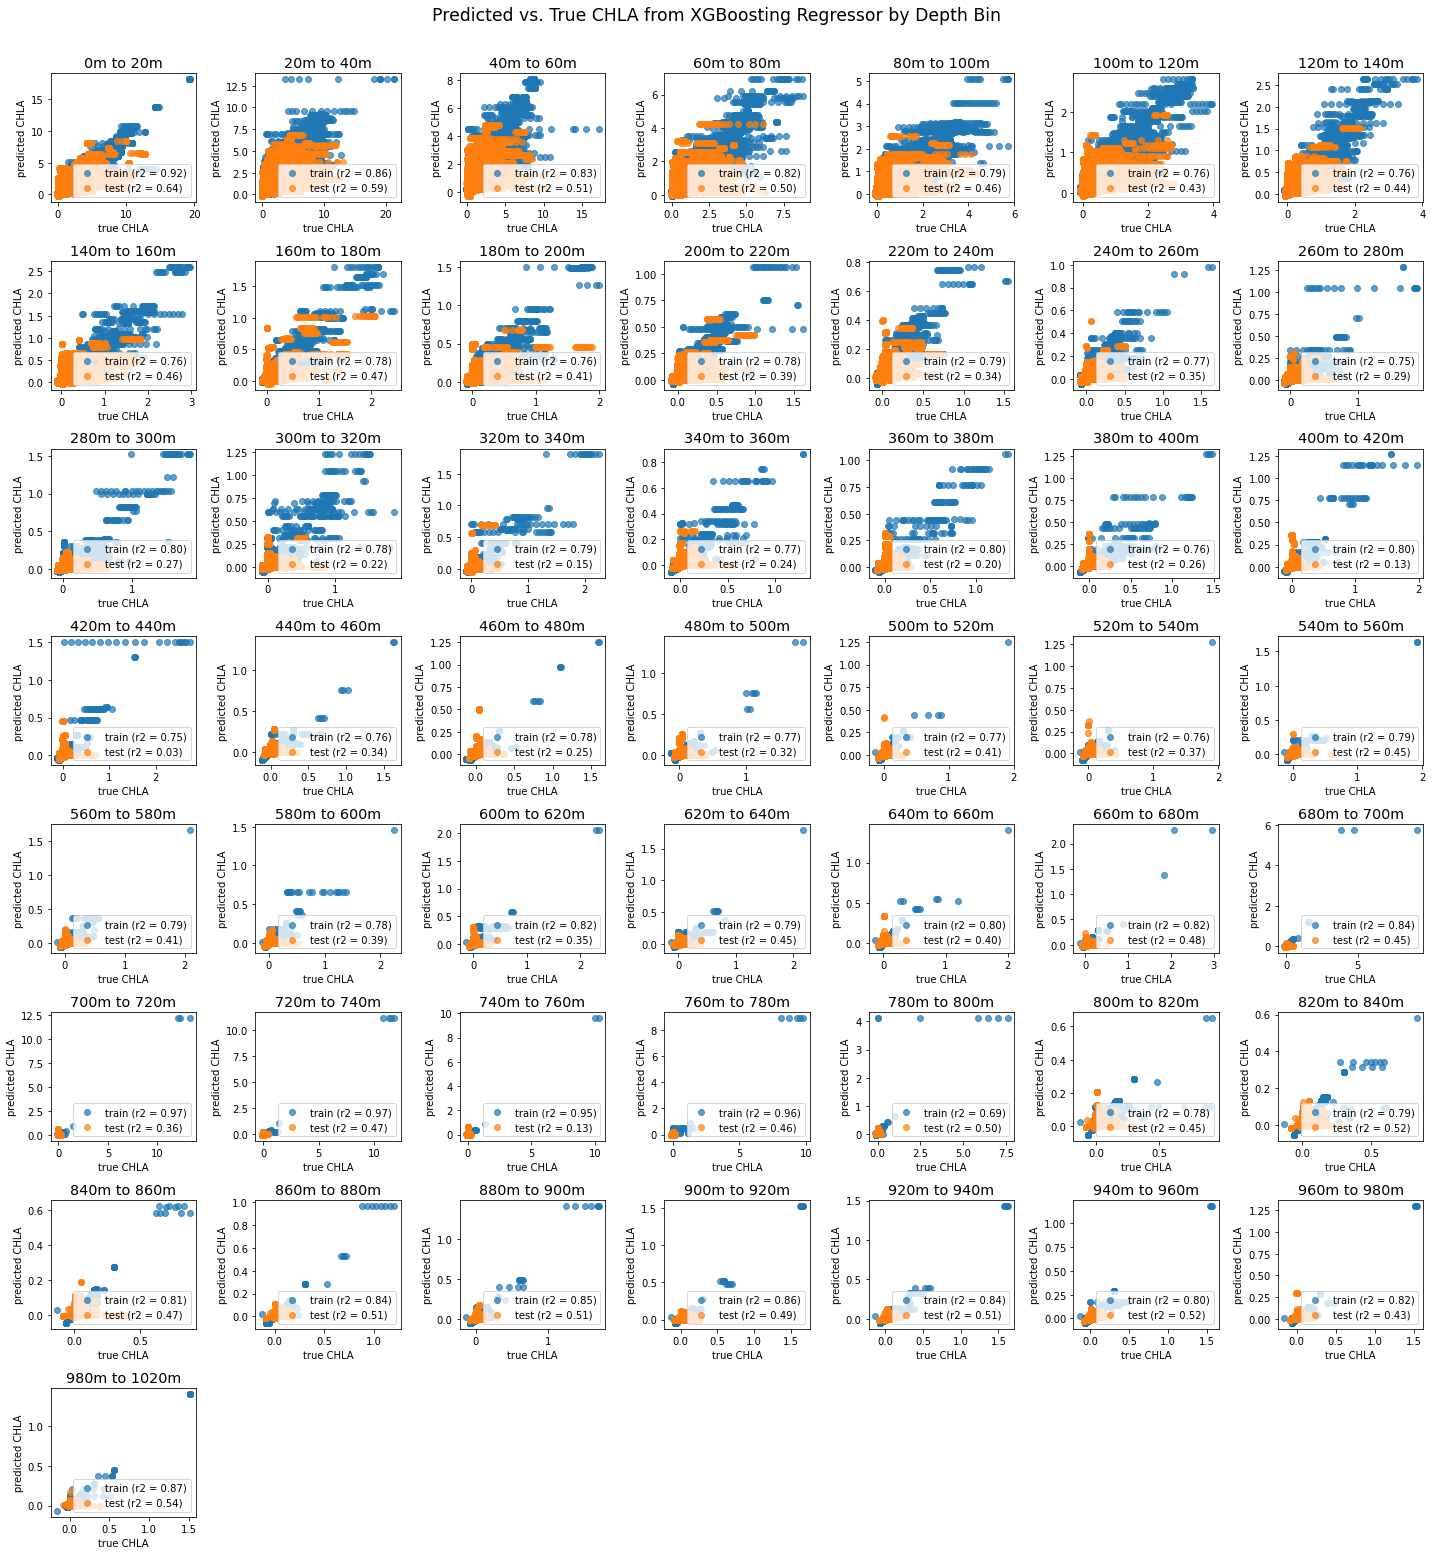

In [21]:
# fit a gradient booting regression model for the ocean at different depth bins
verbose = 1
plt.figure(figsize=(20,22))
plt.suptitle('Predicted vs. True CHLA from XGBoosting Regressor by Depth Bin\n\n', fontsize='xx-large')

for depth_idx in range(len(bins)-1):
    
    if verbose > 0:
        print(f'DEPTH {depth_idx}: {bins[depth_idx]}m to {bins[depth_idx+1]}m')
    
    # obtain train and test data for this bin
    train_data_df, _ = get_data_by_depth(train_df, depth_bin=depth_idx)
    test_data_df, _ = get_data_by_depth(test_df, depth_bin=depth_idx)

    # standardize features based on training data
    X_train, X_test, y_train, y_test = standardize(train_data_df, test_data_df)
        
    if verbose > 0:
        print(f'\tNum train samples: {X_train.shape[0]}', end='  |  ')
        print(f'Num test samples: {X_test.shape[0]}')
    
    # train, predict, and get scores for XGBoosting regressor
    xgbr = XGBRegressor(n_estimators=20, max_depth=10, colsample_bytree=0.6)     # grow_policy = 'depthwise' or 'lossguide'
    train_preds, test_preds = fit_predict(xgbr, X_train, y_train, X_test, y_test)
    
    if verbose > 0: 
        print(f'\tTrain MSE: {mean_squared_error(y_train, train_preds):.4f}', end='  |  ')
        print(f'Train r2: {r2_score(y_train, train_preds):.4f}')
        print(f'\tTest MSE: {mean_squared_error(y_test, test_preds):.4f}', end='   |  ')
        print(f'Test r2: {r2_score(y_test, test_preds):.4f}')
    
    # plot predictions vs. true values
    plot(depth_idx, bins, y_train, train_preds, y_test, test_preds, plt_n_cols=7)
    
    # add scores to results dataframe
    results_df.loc[results_df.shape[0]] = [depth_idx, (bins[depth_idx], bins[depth_idx+1]), train_data_df.shape[0] + test_data_df.shape[0]] + [mean_squared_error(y_train, train_preds), r2_score(y_train, train_preds), mean_squared_error(y_test, test_preds), r2_score(y_test, test_preds)]

    if verbose > 0:
        print()
        
plt.tight_layout()
plt.show()


## Display XGBoost regressor results

In [22]:
# display the dataframe of results
print(f'Average train r2: {np.mean(results_df["train_r2"])}')
print(f'Average test r2: {np.mean(results_df["test_r2"])}')
print(f'\nMaximum train r2: {np.max(results_df["train_r2"])}')
print(f'Maximum test r2: {np.max(results_df["test_r2"])}')
results_df

Average train r2: 0.8092270606394143
Average test r2: 0.39359269726521684

Maximum train r2: 0.9742777896048284
Maximum test r2: 0.6372129969987275


,depth_idx,depth_interval,num_observations,train_mse,train_r2,test_mse,test_r2
0,0,"(0, 20)",937852,0.039517,0.918606,0.186337,0.637213
1,1,"(20, 40)",950809,0.063237,0.863085,0.206817,0.586224
2,2,"(40, 60)",950631,0.044578,0.825284,0.124289,0.513964
3,3,"(60, 80)",949619,0.023377,0.815503,0.058378,0.501569
4,4,"(80, 100)",946022,0.012095,0.790769,0.030619,0.461933
5,5,"(100, 120)",913568,0.006172,0.758264,0.014531,0.425513
6,6,"(120, 140)",914138,0.003321,0.756625,0.006903,0.435728
7,7,"(140, 160)",911918,0.002016,0.761050,0.004347,0.459738
8,8,"(160, 180)",911336,0.001097,0.776841,0.002718,0.466412
9,9,"(180, 200)",911642,0.000655,0.764912,0.001709,0.409781


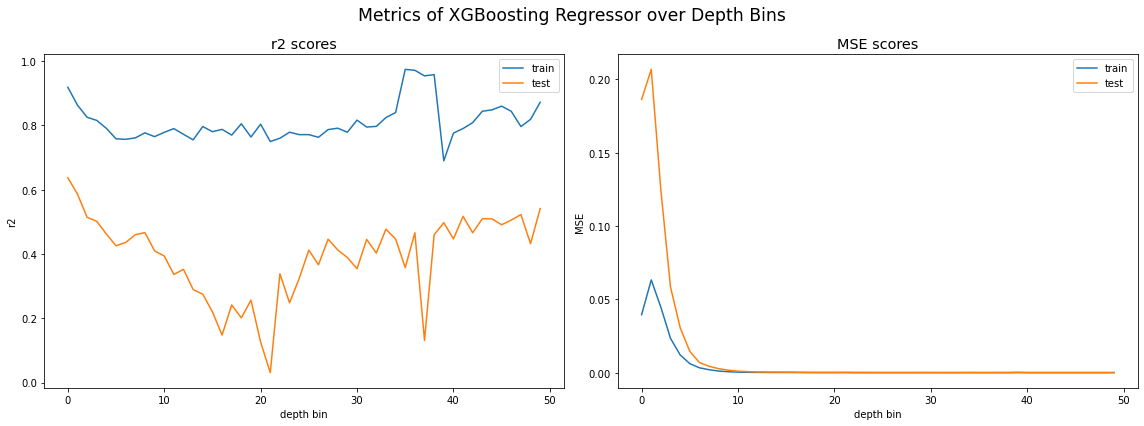

In [23]:
# plot metrics for different depths
plt.figure(figsize=(16,6))
plt.suptitle('Metrics of XGBoosting Regressor over Depth Bins', fontsize='xx-large')

plt.subplot(1,2,1)
plt.plot(range(results_df.shape[0]), results_df['train_r2'], label='train')
plt.plot(range(results_df.shape[0]), results_df['test_r2'], label='test')
plt.title('r2 scores', fontsize='x-large')
plt.xlabel('depth bin')
plt.ylabel('r2')
plt.legend()

plt.subplot(1,2,2)
plt.plot(range(results_df.shape[0]), results_df['train_mse'], label='train')
plt.plot(range(results_df.shape[0]), results_df['test_mse'], label='test')
plt.title('MSE scores', fontsize='x-large')
plt.xlabel('depth bin')
plt.ylabel('MSE')
plt.legend()

plt.tight_layout()
plt.show()


In [24]:
results_df.to_csv('results_xgb_feature_selection_ejd.csv', index=False)


## Repeat for normalized depths
## V1: "invalid" cycles included (i.e., cycles with any euphotic floor detected)

In [25]:
# load merged dataset
path = r'/Users/josiedonnelly/Desktop/DS Capstone ENGIE4800/data/'
file = 'float_sat_normalized_depth_V1.csv'

date_parser = lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
df = pd.read_csv(path + file, parse_dates=['date'], date_parser=date_parser)
df


,float,cycleNumber,latitude,longitude,date,day_of_year_rad,sat_chl,sat_sst,sat_pic,sat_par,sat_aph_443,PRES,normalized_depth,TEMP,CHLA
0,1902303,1,49.236,-14.742,2021-05-06 02:03:16,2.167505,0.370203,12.610,0.000306,27.891998,0.0357,3,0.013274,12.378333,0.695875
1,1902303,1,49.236,-14.742,2021-05-06 02:03:16,2.167505,0.370203,12.610,0.000306,27.891998,0.0357,4,0.017699,12.378333,0.695875
2,1902303,1,49.236,-14.742,2021-05-06 02:03:16,2.167505,0.370203,12.610,0.000306,27.891998,0.0357,6,0.026549,12.378667,0.696499
3,1902303,1,49.236,-14.742,2021-05-06 02:03:16,2.167505,0.370203,12.610,0.000306,27.891998,0.0357,8,0.035398,12.379000,0.716489
4,1902303,1,49.236,-14.742,2021-05-06 02:03:16,2.167505,0.370203,12.610,0.000306,27.891998,0.0357,10,0.044248,12.379000,0.715552
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8225384,7901001,28,17.330,-23.271,2022-05-23 11:34:00,2.459947,0.117684,23.705,0.000142,59.995998,0.0122,152,0.974359,15.741442,0.017077
8225385,7901001,28,17.330,-23.271,2022-05-23 11:34:00,2.459947,0.117684,23.705,0.000142,59.995998,0.0122,153,0.980769,15.645053,0.016121
8225386,7901001,28,17.330,-23.271,2022-05-23 11:34:00,2.459947,0.117684,23.705,0.000142,59.995998,0.0122,154,0.987179,15.576158,0.014904
8225387,7901001,28,17.330,-23.271,2022-05-23 11:34:00,2.459947,0.117684,23.705,0.000142,59.995998,0.0122,155,0.993590,15.528111,0.014600


In [26]:
df.columns
# sat_chl: chlorophyll-a concentration
# sat_sst: sea surface temperature
# sat_pic: calcite concentration
# sat_par: photosynthetically available radiation
# sat_aph_443: absorption due to phytoplankton (443 nm)


Index(['float', 'cycleNumber', 'latitude', 'longitude', 'date',
       'day_of_year_rad', 'sat_chl', 'sat_sst', 'sat_pic', 'sat_par',
       'sat_aph_443', 'PRES', 'normalized_depth', 'TEMP', 'CHLA'],
      dtype='object')

In [27]:
df = df.fillna(value={'normalized_depth': 0.0})     # note: when normalized dataframe is finalized,
                                                    # there will be no missing values; caused by division by zero

In [28]:
print(f'Number of examples for which normalized_depth is missing: {df[df["normalized_depth"].isna()].shape[0]}')


Number of examples for which normalized_depth is missing: 0


In [29]:
# ensure CHLA is not NA for any observations
df.isna().sum()


float                     0
cycleNumber               0
latitude                  0
longitude                 0
date                      0
day_of_year_rad           0
sat_chl             1225625
sat_sst              339976
sat_pic             1326618
sat_par              113251
sat_aph_443         1236837
PRES                      0
normalized_depth          0
TEMP                   2327
CHLA                      0
dtype: int64

In [30]:
# ensure the rows of the dataframe are unique
df.shape[0] == df.drop_duplicates().shape[0]


True

In [31]:
# create train-test-split grouped by float and cycle
df.insert(loc=list(df.columns).index('cycleNumber')+1, column='float_cycle_id', value=[f'{df.loc[i,"float"]}_{df.loc[i,"cycleNumber"]}'for i in range(df.shape[0])])
print(f'Number of float-cycle pairs: {len(np.unique(df["float_cycle_id"]))}')
df


Number of float-cycle pairs: 58413


,float,cycleNumber,float_cycle_id,latitude,longitude,date,day_of_year_rad,sat_chl,sat_sst,sat_pic,sat_par,sat_aph_443,PRES,normalized_depth,TEMP,CHLA
0,1902303,1,1902303_1,49.236,-14.742,2021-05-06 02:03:16,2.167505,0.370203,12.610,0.000306,27.891998,0.0357,3,0.013274,12.378333,0.695875
1,1902303,1,1902303_1,49.236,-14.742,2021-05-06 02:03:16,2.167505,0.370203,12.610,0.000306,27.891998,0.0357,4,0.017699,12.378333,0.695875
2,1902303,1,1902303_1,49.236,-14.742,2021-05-06 02:03:16,2.167505,0.370203,12.610,0.000306,27.891998,0.0357,6,0.026549,12.378667,0.696499
3,1902303,1,1902303_1,49.236,-14.742,2021-05-06 02:03:16,2.167505,0.370203,12.610,0.000306,27.891998,0.0357,8,0.035398,12.379000,0.716489
4,1902303,1,1902303_1,49.236,-14.742,2021-05-06 02:03:16,2.167505,0.370203,12.610,0.000306,27.891998,0.0357,10,0.044248,12.379000,0.715552
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8225384,7901001,28,7901001_28,17.330,-23.271,2022-05-23 11:34:00,2.459947,0.117684,23.705,0.000142,59.995998,0.0122,152,0.974359,15.741442,0.017077
8225385,7901001,28,7901001_28,17.330,-23.271,2022-05-23 11:34:00,2.459947,0.117684,23.705,0.000142,59.995998,0.0122,153,0.980769,15.645053,0.016121
8225386,7901001,28,7901001_28,17.330,-23.271,2022-05-23 11:34:00,2.459947,0.117684,23.705,0.000142,59.995998,0.0122,154,0.987179,15.576158,0.014904
8225387,7901001,28,7901001_28,17.330,-23.271,2022-05-23 11:34:00,2.459947,0.117684,23.705,0.000142,59.995998,0.0122,155,0.993590,15.528111,0.014600


In [32]:
# split data indices into train and test dataframes grouped by float_cycle_id
from sklearn.model_selection import GroupShuffleSplit
splitter = GroupShuffleSplit(test_size=0.2, n_splits=1, random_state=42)
split = splitter.split(df, groups=df['float_cycle_id'])
train_inds, test_inds = next(split)

print(f'Number of train observations: {len(train_inds)}')
print(f'Number of float-cycle observations: {len(test_inds)}')

# obtain train and test dataframes
train_df = df.loc[train_inds]
test_df = df.loc[test_inds]

# ensure that the train and test float cycles are distinct
train_float_cycles = np.unique(train_df['float_cycle_id'])
test_float_cycles = np.unique(test_df['float_cycle_id'])
print(f'\nNumber of unique train float-cycles: {len(np.unique(train_float_cycles))}')
print(f'Number of unique test float-cycles: {len(np.unique(test_float_cycles))}')
print(f'Number of float-cycle pairs in both train and test sets: {len(np.intersect1d(train_float_cycles, test_float_cycles))}')


Number of train observations: 6573548
Number of float-cycle observations: 1651841

Number of unique train float-cycles: 46730
Number of unique test float-cycles: 11683
Number of float-cycle pairs in both train and test sets: 0


In [33]:
# define depth bins
interval = 0.1
bins = np.arange(0, 1+interval, interval)
bins
depth_bins = pd.cut(df['normalized_depth'], bins=bins, right=True, labels=False, retbins=False, include_lowest=True)

try:
    train_df = train_df.drop(columns='depth_bin')
except:
    pass
train_df.insert(loc=list(train_df.columns).index('normalized_depth')+1, column='depth_bin', value=depth_bins)

try:
    test_df = test_df.drop(columns='depth_bin')
except:
    pass
test_df.insert(loc=list(test_df.columns).index('normalized_depth')+1, column='depth_bin', value=depth_bins)


In [34]:
# initialize dataframes to store results and predictions
results_df = pd.DataFrame(columns=['depth_bin', 'depth_interval', 'num_observations', 'train_mse', 'train_r2', 'test_mse', 'test_r2'])
train_predictions_df = pd.DataFrame(columns=['depth_bin', 'depth_interval', 'float_cycle_id', 'date', 'PRES', 'normalized_depth', 'true_CHLA', 'pred_CHLA'])
test_predictions_df = pd.DataFrame(columns=['depth_bin', 'depth_interval', 'float_cycle_id', 'date', 'PRES', 'normalized_depth', 'true_CHLA', 'pred_CHLA'])


DEPTH 0: 0% to 10% of the euphotic zone
	Num train samples: 651592  |  Num test samples: 163769
	Train MSE: 0.0260  |  Train r2: 0.9273
	Test MSE: 0.1274   |  Test r2: 0.6644

DEPTH 1: 10% to 20% of the euphotic zone
	Num train samples: 684951  |  Num test samples: 171884
	Train MSE: 0.0328  |  Train r2: 0.9115
	Test MSE: 0.1308   |  Test r2: 0.6621

DEPTH 2: 20% to 30% of the euphotic zone
	Num train samples: 678270  |  Num test samples: 170094
	Train MSE: 0.0327  |  Train r2: 0.9025
	Test MSE: 0.1180   |  Test r2: 0.6604

DEPTH 3: 30% to 40% of the euphotic zone
	Num train samples: 679572  |  Num test samples: 170542
	Train MSE: 0.0306  |  Train r2: 0.8779
	Test MSE: 0.1047   |  Test r2: 0.6209

DEPTH 4: 40% to 50% of the euphotic zone
	Num train samples: 674892  |  Num test samples: 169075
	Train MSE: 0.0227  |  Train r2: 0.8579
	Test MSE: 0.0745   |  Test r2: 0.5562

DEPTH 5: 50% to 60% of the euphotic zone
	Num train samples: 647912  |  Num test samples: 162749
	Train MSE: 0.0139 

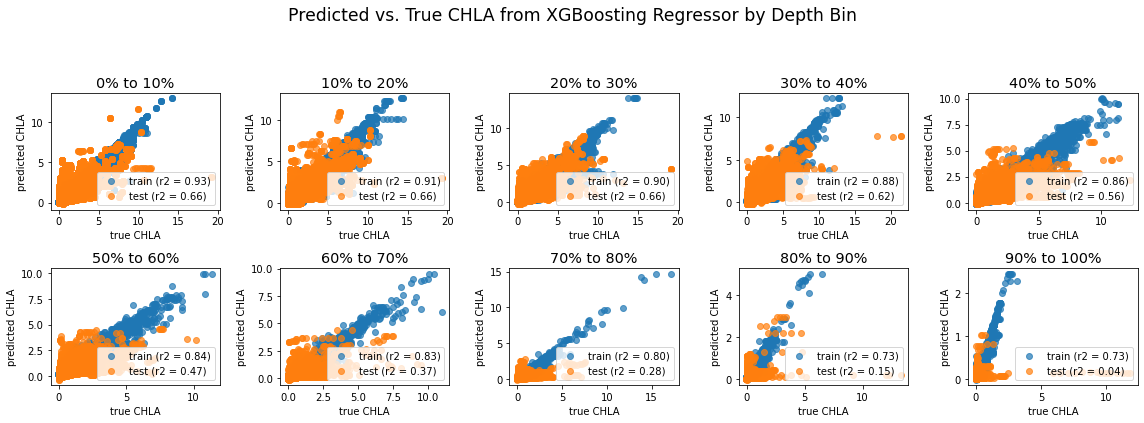

In [35]:
# fit a gradient booting regression model for the ocean at different depth bins
verbose = 1
plt.figure(figsize=(16,8))
plt.suptitle('Predicted vs. True CHLA from XGBoosting Regressor by Depth Bin\n\n', fontsize='xx-large')

for depth_idx in range(len(bins)-1):
    
    if verbose > 0:
        print(f'DEPTH {depth_idx}: {int(bins[depth_idx]*100)}% to {int(bins[depth_idx+1]*100)}% of the euphotic zone')
    
    # obtain train and test data for this bin
    train_data_df, train_predictions_for_depth_df = get_data_by_depth(train_df, depth_bin=depth_idx)
    test_data_df, test_predictions_for_depth_df = get_data_by_depth(test_df, depth_bin=depth_idx)
    
    train_predictions_for_depth_df.insert(loc=list(train_predictions_for_depth_df.columns).index('depth_bin')+1, column='depth_interval', value=[(int(bins[depth_idx]*100), int(bins[depth_idx+1]*100)) for i in range(train_predictions_for_depth_df.shape[0])])
    test_predictions_for_depth_df.insert(loc=list(test_predictions_for_depth_df.columns).index('depth_bin')+1, column='depth_interval', value=[(int(bins[depth_idx]*100), int(bins[depth_idx+1]*100)) for i in range(test_predictions_for_depth_df.shape[0])])
    
    # standardize features based on training data
    X_train, X_test, y_train, y_test = standardize(train_data_df, test_data_df)

    if verbose > 0:
        print(f'\tNum train samples: {X_train.shape[0]}', end='  |  ')
        print(f'Num test samples: {X_test.shape[0]}')
    
    # train, predict, and get scores for XGBoosting regressor
    xgbr = XGBRegressor(n_estimators=20, max_depth=10, colsample_bytree=0.8)     # grow_policy = 'depthwise' or 'lossguide'
    train_preds, test_preds = fit_predict(xgbr, X_train, y_train, X_test, y_test)
    
    if verbose > 0: 
        print(f'\tTrain MSE: {mean_squared_error(y_train, train_preds):.4f}', end='  |  ')
        print(f'Train r2: {r2_score(y_train, train_preds):.4f}')
        print(f'\tTest MSE: {mean_squared_error(y_test, test_preds):.4f}', end='   |  ')
        print(f'Test r2: {r2_score(y_test, test_preds):.4f}')
    
    # plot predictions vs. true values
    plot(depth_idx, bins, y_train, train_preds, y_test, test_preds, normalized=True, plt_n_cols=5)
    
    # add scores and predictions to respective dataframes
    results_df.loc[results_df.shape[0]] = [depth_idx, (int(bins[depth_idx]*100), int(bins[depth_idx+1]*100)), train_data_df.shape[0] + test_data_df.shape[0]] + [mean_squared_error(y_train, train_preds), r2_score(y_train, train_preds), mean_squared_error(y_test, test_preds), r2_score(y_test, test_preds)]
    train_predictions_for_depth_df['pred_CHLA'] = train_preds
    train_predictions_df = pd.concat([train_predictions_df, train_predictions_for_depth_df])
    test_predictions_for_depth_df['pred_CHLA'] = test_preds
    test_predictions_df = pd.concat([test_predictions_df, test_predictions_for_depth_df])
    
    if verbose > 0:
        print()
        
plt.tight_layout()
plt.show()


In [36]:
# display the dataframe of results
print(f'Average train r2: {np.mean(results_df["train_r2"])}')
print(f'Average test r2: {np.mean(results_df["test_r2"])}')
print(f'\nMaximum train r2: {np.max(results_df["train_r2"])}')
print(f'Maximum test r2: {np.max(results_df["test_r2"])}')
results_df


Average train r2: 0.8403345076553542
Average test r2: 0.4469497213500583

Maximum train r2: 0.9273197971325727
Maximum test r2: 0.6643676119303468


,depth_bin,depth_interval,num_observations,train_mse,train_r2,test_mse,test_r2
0,0,"(0, 10)",815361,0.025956,0.927320,0.127428,0.664368
1,1,"(10, 20)",856835,0.032809,0.911543,0.130814,0.662120
2,2,"(20, 30)",848364,0.032725,0.902531,0.118005,0.660393
3,3,"(30, 40)",850114,0.030612,0.877897,0.104733,0.620912
4,4,"(40, 50)",843967,0.022685,0.857928,0.074493,0.556224
5,5,"(50, 60)",810661,0.013907,0.843405,0.049621,0.466325
6,6,"(60, 70)",803589,0.007555,0.827052,0.031654,0.369010
7,7,"(70, 80)",798477,0.003756,0.803670,0.016767,0.277113
8,8,"(80, 90)",786802,0.001572,0.726923,0.008852,0.154215
9,9,"(90, 100)",811219,0.000444,0.725075,0.009159,0.038816


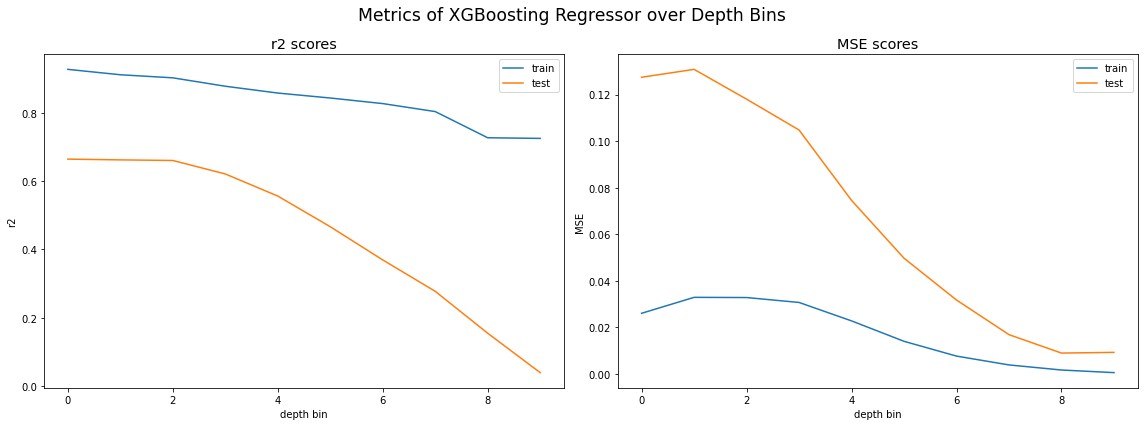

In [37]:
# plot metrics for different depths
plt.figure(figsize=(16,6))
plt.suptitle('Metrics of XGBoosting Regressor over Depth Bins', fontsize='xx-large')

plt.subplot(1,2,1)
plt.plot(range(results_df.shape[0]), results_df['train_r2'], label='train')
plt.plot(range(results_df.shape[0]), results_df['test_r2'], label='test')
plt.title('r2 scores', fontsize='x-large')
plt.xlabel('depth bin')
plt.ylabel('r2')
plt.legend()

plt.subplot(1,2,2)
plt.plot(range(results_df.shape[0]), results_df['train_mse'], label='train')
plt.plot(range(results_df.shape[0]), results_df['test_mse'], label='test')
plt.title('MSE scores', fontsize='x-large')
plt.xlabel('depth bin')
plt.ylabel('MSE')
plt.legend()

plt.tight_layout()
plt.show()


In [38]:
# save results
results_df.to_csv('results_xgb_feature_selection_normalized_ejd_V1.csv', index=False)


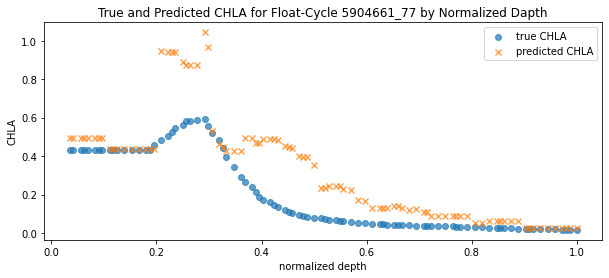

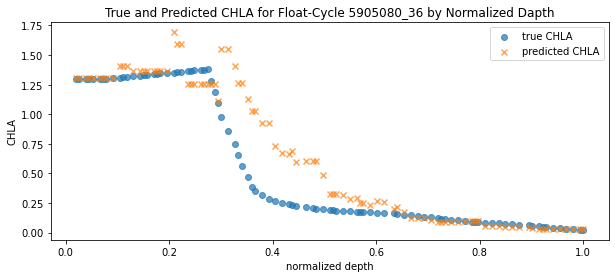

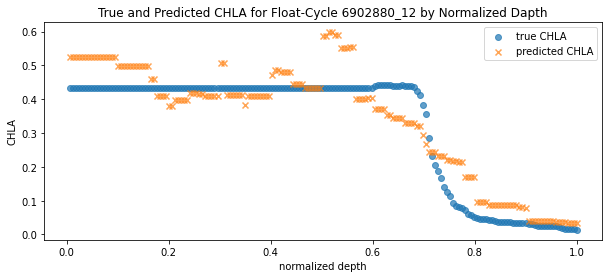

In [39]:
# display results for a few example float-cycles
for c in random.choices(test_float_cycles, k=3):
    tmp_df = test_predictions_df[test_predictions_df['float_cycle_id'] == c]
    plt.figure(figsize=(10,4))
    plt.scatter(tmp_df['normalized_depth'], tmp_df['true_CHLA'], alpha=0.7, marker='o', label='true CHLA')
    plt.scatter(tmp_df['normalized_depth'], tmp_df['pred_CHLA'], alpha=0.7, marker='x', label='predicted CHLA')
    plt.title(f'True and Predicted CHLA for Float-Cycle {c} by Normalized Dapth')
    plt.xlabel('normalized depth')
    plt.ylabel('CHLA')
    plt.legend()
    plt.show()
    

## Repeat for normalized depths
## V2: Only includes cycles for which the euphotic floor is >=75m and <=250m

In [6]:
# load merged dataset
path = r'/Users/josiedonnelly/Desktop/DS Capstone ENGIE4800/data/'
file = 'float_sat_normalized_depth.csv'

date_parser = lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
df = pd.read_csv(path + file, parse_dates=['date'], date_parser=date_parser)
df


,float,cycleNumber,latitude,longitude,date,day_of_year_rad,sat_chl,sat_sst,sat_pic,sat_par,sat_aph_443,PRES,normalized_depth,TEMP,CHLA
0,1902303,1,49.236,-14.742,2021-05-06 02:03:16,2.167505,0.370203,12.610,0.000306,27.891998,0.0357,3,0.013274,12.378333,0.695875
1,1902303,1,49.236,-14.742,2021-05-06 02:03:16,2.167505,0.370203,12.610,0.000306,27.891998,0.0357,4,0.017699,12.378333,0.695875
2,1902303,1,49.236,-14.742,2021-05-06 02:03:16,2.167505,0.370203,12.610,0.000306,27.891998,0.0357,6,0.026549,12.378667,0.696499
3,1902303,1,49.236,-14.742,2021-05-06 02:03:16,2.167505,0.370203,12.610,0.000306,27.891998,0.0357,8,0.035398,12.379000,0.716489
4,1902303,1,49.236,-14.742,2021-05-06 02:03:16,2.167505,0.370203,12.610,0.000306,27.891998,0.0357,10,0.044248,12.379000,0.715552
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6850808,7901001,28,17.330,-23.271,2022-05-23 11:34:00,2.459947,0.117684,23.705,0.000142,59.995998,0.0122,152,0.974359,15.741442,0.017077
6850809,7901001,28,17.330,-23.271,2022-05-23 11:34:00,2.459947,0.117684,23.705,0.000142,59.995998,0.0122,153,0.980769,15.645053,0.016121
6850810,7901001,28,17.330,-23.271,2022-05-23 11:34:00,2.459947,0.117684,23.705,0.000142,59.995998,0.0122,154,0.987179,15.576158,0.014904
6850811,7901001,28,17.330,-23.271,2022-05-23 11:34:00,2.459947,0.117684,23.705,0.000142,59.995998,0.0122,155,0.993590,15.528111,0.014600


In [7]:
df.columns
# sat_chl: chlorophyll-a concentration
# sat_sst: sea surface temperature
# sat_pic: calcite concentration
# sat_par: photosynthetically available radiation
# sat_aph_443: absorption due to phytoplankton (443 nm)


Index(['float', 'cycleNumber', 'latitude', 'longitude', 'date',
       'day_of_year_rad', 'sat_chl', 'sat_sst', 'sat_pic', 'sat_par',
       'sat_aph_443', 'PRES', 'normalized_depth', 'TEMP', 'CHLA'],
      dtype='object')

In [9]:
print(f'Number of examples for which normalized_depth is missing: {df[df["normalized_depth"].isna()].shape[0]}')
# also ensure CHLA is not NA for any observations
df.isna().sum()


Number of examples for which normalized_depth is missing: 0


float                    0
cycleNumber              0
latitude                 0
longitude                0
date                     0
day_of_year_rad          0
sat_chl             928872
sat_sst             275198
sat_pic             985501
sat_par              89375
sat_aph_443         938206
PRES                     0
normalized_depth         0
TEMP                  1617
CHLA                     0
dtype: int64

In [10]:
# ensure the rows of the dataframe are unique
df.shape[0] == df.drop_duplicates().shape[0]


True

In [11]:
# create train-test-split grouped by float and cycle
df.insert(loc=list(df.columns).index('cycleNumber')+1, column='float_cycle_id', value=[f'{df.loc[i,"float"]}_{df.loc[i,"cycleNumber"]}'for i in range(df.shape[0])])
print(f'Number of float-cycle pairs: {len(np.unique(df["float_cycle_id"]))}')
df


Number of float-cycle pairs: 51953


,float,cycleNumber,float_cycle_id,latitude,longitude,date,day_of_year_rad,sat_chl,sat_sst,sat_pic,sat_par,sat_aph_443,PRES,normalized_depth,TEMP,CHLA
0,1902303,1,1902303_1,49.236,-14.742,2021-05-06 02:03:16,2.167505,0.370203,12.610,0.000306,27.891998,0.0357,3,0.013274,12.378333,0.695875
1,1902303,1,1902303_1,49.236,-14.742,2021-05-06 02:03:16,2.167505,0.370203,12.610,0.000306,27.891998,0.0357,4,0.017699,12.378333,0.695875
2,1902303,1,1902303_1,49.236,-14.742,2021-05-06 02:03:16,2.167505,0.370203,12.610,0.000306,27.891998,0.0357,6,0.026549,12.378667,0.696499
3,1902303,1,1902303_1,49.236,-14.742,2021-05-06 02:03:16,2.167505,0.370203,12.610,0.000306,27.891998,0.0357,8,0.035398,12.379000,0.716489
4,1902303,1,1902303_1,49.236,-14.742,2021-05-06 02:03:16,2.167505,0.370203,12.610,0.000306,27.891998,0.0357,10,0.044248,12.379000,0.715552
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6850808,7901001,28,7901001_28,17.330,-23.271,2022-05-23 11:34:00,2.459947,0.117684,23.705,0.000142,59.995998,0.0122,152,0.974359,15.741442,0.017077
6850809,7901001,28,7901001_28,17.330,-23.271,2022-05-23 11:34:00,2.459947,0.117684,23.705,0.000142,59.995998,0.0122,153,0.980769,15.645053,0.016121
6850810,7901001,28,7901001_28,17.330,-23.271,2022-05-23 11:34:00,2.459947,0.117684,23.705,0.000142,59.995998,0.0122,154,0.987179,15.576158,0.014904
6850811,7901001,28,7901001_28,17.330,-23.271,2022-05-23 11:34:00,2.459947,0.117684,23.705,0.000142,59.995998,0.0122,155,0.993590,15.528111,0.014600


In [12]:
# split data indices into train and test dataframes grouped by float_cycle_id
from sklearn.model_selection import GroupShuffleSplit
splitter = GroupShuffleSplit(test_size=0.2, n_splits=1, random_state=42)
split = splitter.split(df, groups=df['float_cycle_id'])
train_inds, test_inds = next(split)

print(f'Number of train observations: {len(train_inds)}')
print(f'Number of float-cycle observations: {len(test_inds)}')

# obtain train and test dataframes
train_df = df.loc[train_inds]
test_df = df.loc[test_inds]

# ensure that the train and test float cycles are distinct
train_float_cycles = np.unique(train_df['float_cycle_id'])
test_float_cycles = np.unique(test_df['float_cycle_id'])
print(f'\nNumber of unique train float-cycles: {len(np.unique(train_float_cycles))}')
print(f'Number of unique test float-cycles: {len(np.unique(test_float_cycles))}')
print(f'Number of float-cycle pairs in both train and test sets: {len(np.intersect1d(train_float_cycles, test_float_cycles))}')


Number of train observations: 5476113
Number of float-cycle observations: 1374700

Number of unique train float-cycles: 41562
Number of unique test float-cycles: 10391
Number of float-cycle pairs in both train and test sets: 0


In [13]:
# define depth bins
interval = 0.1
bins = np.arange(0, 1+interval, interval)
bins
depth_bins = pd.cut(df['normalized_depth'], bins=bins, right=True, labels=False, retbins=False, include_lowest=True)

try:
    train_df = train_df.drop(columns='depth_bin')
except:
    pass
train_df.insert(loc=list(train_df.columns).index('normalized_depth')+1, column='depth_bin', value=depth_bins)

try:
    test_df = test_df.drop(columns='depth_bin')
except:
    pass
test_df.insert(loc=list(test_df.columns).index('normalized_depth')+1, column='depth_bin', value=depth_bins)


In [14]:
# initialize dataframes to store results and predictions
results_df = pd.DataFrame(columns=['depth_bin', 'depth_interval', 'num_observations', 'train_mse', 'train_r2', 'test_mse', 'test_r2'])
train_predictions_df = pd.DataFrame(columns=['depth_bin', 'depth_interval', 'float_cycle_id', 'date', 'PRES', 'normalized_depth', 'true_CHLA', 'pred_CHLA'])
test_predictions_df = pd.DataFrame(columns=['depth_bin', 'depth_interval', 'float_cycle_id', 'date', 'PRES', 'normalized_depth', 'true_CHLA', 'pred_CHLA'])


DEPTH 0: 0% to 10% of the euphotic zone
	Num train samples: 530607  |  Num test samples: 133338
	Train MSE: 0.0243  |  Train r2: 0.9372
	Test MSE: 0.1297   |  Test r2: 0.6567

DEPTH 1: 10% to 20% of the euphotic zone
	Num train samples: 559948  |  Num test samples: 140546
	Train MSE: 0.0281  |  Train r2: 0.9315
	Test MSE: 0.1384   |  Test r2: 0.6488

DEPTH 2: 20% to 30% of the euphotic zone
	Num train samples: 555400  |  Num test samples: 139255
	Train MSE: 0.0312  |  Train r2: 0.9178
	Test MSE: 0.1170   |  Test r2: 0.6534

DEPTH 3: 30% to 40% of the euphotic zone
	Num train samples: 559610  |  Num test samples: 140538
	Train MSE: 0.0294  |  Train r2: 0.8952
	Test MSE: 0.0934   |  Test r2: 0.6071

DEPTH 4: 40% to 50% of the euphotic zone
	Num train samples: 560655  |  Num test samples: 140710
	Train MSE: 0.0226  |  Train r2: 0.8625
	Test MSE: 0.0695   |  Test r2: 0.5534

DEPTH 5: 50% to 60% of the euphotic zone
	Num train samples: 541109  |  Num test samples: 135847
	Train MSE: 0.0144 

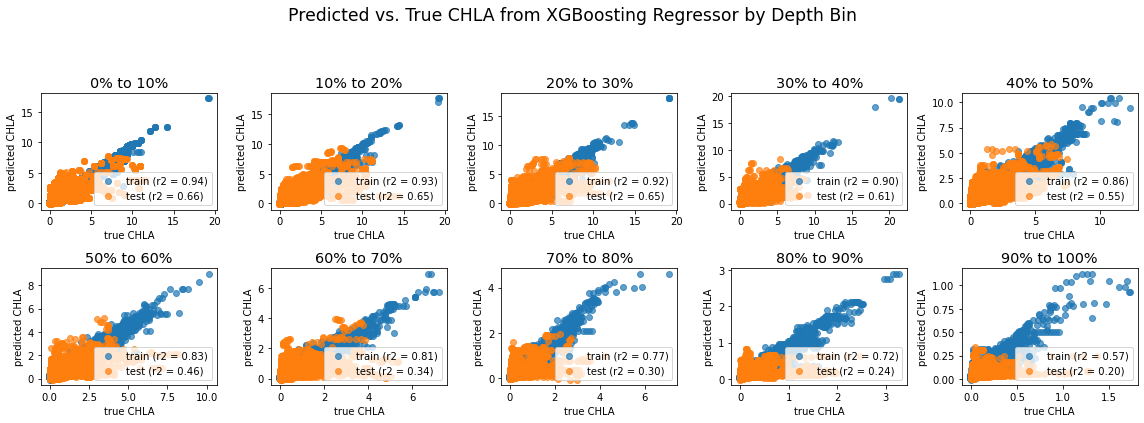

In [15]:
# fit a gradient booting regression model for the ocean at different depth bins
verbose = 1
plt.figure(figsize=(16,8))
plt.suptitle('Predicted vs. True CHLA from XGBoosting Regressor by Depth Bin\n\n', fontsize='xx-large')

for depth_idx in range(len(bins)-1):
    
    if verbose > 0:
        print(f'DEPTH {depth_idx}: {int(bins[depth_idx]*100)}% to {int(bins[depth_idx+1]*100)}% of the euphotic zone')
    
    # obtain train and test data for this bin
    train_data_df, train_predictions_for_depth_df = get_data_by_depth(train_df, depth_bin=depth_idx)
    test_data_df, test_predictions_for_depth_df = get_data_by_depth(test_df, depth_bin=depth_idx)
    
    train_predictions_for_depth_df.insert(loc=list(train_predictions_for_depth_df.columns).index('depth_bin')+1, column='depth_interval', value=[(int(bins[depth_idx]*100), int(bins[depth_idx+1]*100)) for i in range(train_predictions_for_depth_df.shape[0])])
    test_predictions_for_depth_df.insert(loc=list(test_predictions_for_depth_df.columns).index('depth_bin')+1, column='depth_interval', value=[(int(bins[depth_idx]*100), int(bins[depth_idx+1]*100)) for i in range(test_predictions_for_depth_df.shape[0])])
    
    # standardize features based on training data
    X_train, X_test, y_train, y_test = standardize(train_data_df, test_data_df)

    if verbose > 0:
        print(f'\tNum train samples: {X_train.shape[0]}', end='  |  ')
        print(f'Num test samples: {X_test.shape[0]}')
    
    # train, predict, and get scores for XGBoosting regressor
    xgbr = XGBRegressor(n_estimators=20, max_depth=10, colsample_bytree=0.8)     # grow_policy = 'depthwise' or 'lossguide'
    train_preds, test_preds = fit_predict(xgbr, X_train, y_train, X_test, y_test)
    
    if verbose > 0: 
        print(f'\tTrain MSE: {mean_squared_error(y_train, train_preds):.4f}', end='  |  ')
        print(f'Train r2: {r2_score(y_train, train_preds):.4f}')
        print(f'\tTest MSE: {mean_squared_error(y_test, test_preds):.4f}', end='   |  ')
        print(f'Test r2: {r2_score(y_test, test_preds):.4f}')
    
    # plot predictions vs. true values
    plot(depth_idx, bins, y_train, train_preds, y_test, test_preds, normalized=True, plt_n_cols=5)
    
    # add scores and predictions to respective dataframes
    results_df.loc[results_df.shape[0]] = [depth_idx, (int(bins[depth_idx]*100), int(bins[depth_idx+1]*100)), train_data_df.shape[0] + test_data_df.shape[0]] + [mean_squared_error(y_train, train_preds), r2_score(y_train, train_preds), mean_squared_error(y_test, test_preds), r2_score(y_test, test_preds)]
    train_predictions_for_depth_df['pred_CHLA'] = train_preds
    train_predictions_df = pd.concat([train_predictions_df, train_predictions_for_depth_df])
    test_predictions_for_depth_df['pred_CHLA'] = test_preds
    test_predictions_df = pd.concat([test_predictions_df, test_predictions_for_depth_df])
    
    if verbose > 0:
        print()
        
plt.tight_layout()
plt.show()


In [16]:
# display the dataframe of results
print(f'Average train r2: {np.mean(results_df["train_r2"])}')
print(f'Average test r2: {np.mean(results_df["test_r2"])}')
print(f'\nMaximum train r2: {np.max(results_df["train_r2"])}')
print(f'Maximum test r2: {np.max(results_df["test_r2"])}')
results_df


Average train r2: 0.8251781956298645
Average test r2: 0.46584158310021523

Maximum train r2: 0.937228151553331
Maximum test r2: 0.6566627095940858


,depth_bin,depth_interval,num_observations,train_mse,train_r2,test_mse,test_r2
0,0,"(0, 10)",663945,0.024344,0.937228,0.129735,0.656663
1,1,"(10, 20)",700494,0.028056,0.931531,0.138433,0.648808
2,2,"(20, 30)",694655,0.031171,0.917775,0.116980,0.653374
3,3,"(30, 40)",700148,0.029433,0.895250,0.093416,0.607077
4,4,"(40, 50)",701365,0.022633,0.862531,0.069498,0.553405
5,5,"(50, 60)",676956,0.014359,0.831181,0.046827,0.461427
6,6,"(60, 70)",675921,0.007399,0.810209,0.027323,0.340463
7,7,"(70, 80)",675428,0.003729,0.767969,0.011218,0.298150
8,8,"(80, 90)",668684,0.001440,0.724648,0.003640,0.243861
9,9,"(90, 100)",693217,0.000399,0.573462,0.000743,0.195187


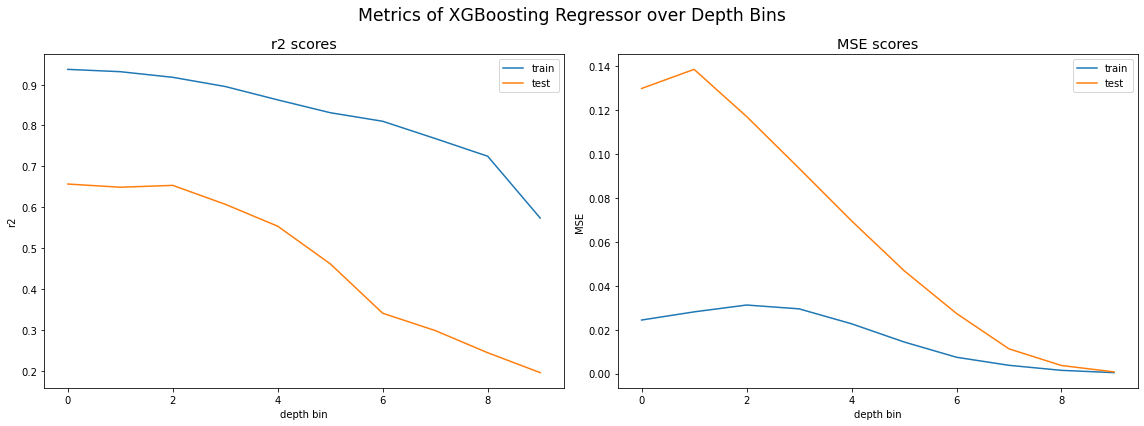

In [17]:
# plot metrics for different depths
plt.figure(figsize=(16,6))
plt.suptitle('Metrics of XGBoosting Regressor over Depth Bins', fontsize='xx-large')

plt.subplot(1,2,1)
plt.plot(range(results_df.shape[0]), results_df['train_r2'], label='train')
plt.plot(range(results_df.shape[0]), results_df['test_r2'], label='test')
plt.title('r2 scores', fontsize='x-large')
plt.xlabel('depth bin')
plt.ylabel('r2')
plt.legend()

plt.subplot(1,2,2)
plt.plot(range(results_df.shape[0]), results_df['train_mse'], label='train')
plt.plot(range(results_df.shape[0]), results_df['test_mse'], label='test')
plt.title('MSE scores', fontsize='x-large')
plt.xlabel('depth bin')
plt.ylabel('MSE')
plt.legend()

plt.tight_layout()
plt.show()


In [18]:
# save results
results_df.to_csv('results_xgb_feature_selection_normalized_ejd.csv', index=False)


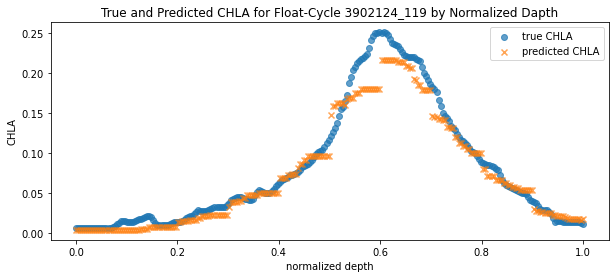

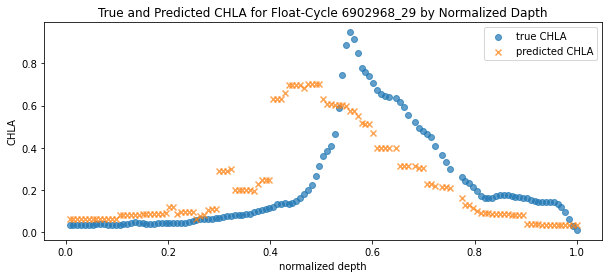

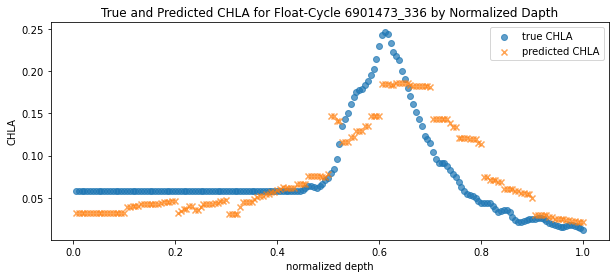

In [19]:
# display results for a few example float-cycles
for c in random.choices(test_float_cycles, k=3):
    tmp_df = test_predictions_df[test_predictions_df['float_cycle_id'] == c]
    plt.figure(figsize=(10,4))
    plt.scatter(tmp_df['normalized_depth'], tmp_df['true_CHLA'], alpha=0.7, marker='o', label='true CHLA')
    plt.scatter(tmp_df['normalized_depth'], tmp_df['pred_CHLA'], alpha=0.7, marker='x', label='predicted CHLA')
    plt.title(f'True and Predicted CHLA for Float-Cycle {c} by Normalized Dapth')
    plt.xlabel('normalized depth')
    plt.ylabel('CHLA')
    plt.legend()
    plt.show()
    